<a href="https://colab.research.google.com/github/sg2083/datman/blob/main/FPI_vs_Inflation_PS5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analyzing US Food Prices and Inflation Trends**

Food prices and inflation are two critical economic indicators that influence global markets, policymaking, and household consumption patterns. Over the past few decades, food prices have shown considerable volatility due to factors such as climate change, supply chain disruptions, geopolitical events, and economic policies. Understanding the relationship between food price inflation and general inflation is essential for governments, businesses, and consumers to make informed decisions regarding food security, economic stability, and policy interventions.

Things to know about this project:
1.   **Consumer Price Index (CPI)** 📈 – This is the most direct measure of inflation. If the CPI goes up, it means everyday goods and services are getting more expensive, which reduces the purchasing power of money. Central banks and governments use CPI to adjust policies, like interest rates, to control inflation.

2.  **Producer Price Index (PPI)** 🏭 – This shows how much businesses are paying for materials and services. If PPI rises, businesses might pass those higher costs to consumers by increasing prices, which then raises CPI and contributes to inflation.

3.   **Food Price Index (FPI)** 🍞 – Food prices are a big part of household expenses.If FPI rises significantly, CPI also tends to rise because food is essential for everyone. High food inflation can lead to higher overall inflation.

This project integrates multiple datasets from global organizations like the **FAO (Food and Agriculture Organization)** and the **World Bank** to ensure a comprehensive analysis. The datasets include:

- [Food Price Index (FPI) Data](https://www.fao.org/worldfoodsituation/FoodPricesIndex/en/) – Annual indices for food prices and subcategories (cereals, dairy, etc.), including nominal and real values.
- [World Bank Inflation Data](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG) – Annual CPI-based inflation rates for multiple countries, aggregated into a global average inflation index.
- [Food Price Indices - Nominal vs Real](https://www.fao.org/worldfoodsituation/FoodPricesIndex/en/) – Annual nominal vs real FPI data
- [Median Household Income by State](https://fred.stlouisfed.org/release/tables?eid=259515&rid=249) – Median Household Income by State over the years 2000 to 2023
- [Living wage By State](https://livingwage.mit.edu/) - Living wage by state over the years 2012 to 2023

### Steps taken during the process of data processing

- Data Cleaning: Handling missing values, renaming columns, and ensuring data consistency.
- Data Transformation: Reshaping wide-format inflation data into long-format for better analysis, converting data types, and aggregating global inflation rates.
- Data Integration: Merging datasets using Year as the common key.

Food price inflation and general inflation are linked in a cycle—rising food costs contribute to inflation, and inflation makes food even more expensive. Governments often monitor food prices closely because they affect household budgets and economic stability.

### **The Goal**:
 The objective is to analyze the projected trends in food price indexes and inflation, and to assess how this information can be utilized to support policy decisions aimed at maintaining stable and sustained economic growth.

In [ ]:
!pip install prophet
!pip install adjustText

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import numpy as np

In [ ]:
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/FPI_nominal_vs_real.json -O fpi_nominal_real.json
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/food_price_indices_data.xlsx -O fpi_categories.xlsx
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/inflation_cpi_data.csv -O inflation_data.csv
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/US_inflation_rate.csv -O US_inflation_rate.csv
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/Food_Inflation_us.xlsx -O Food_Inflation_us.xlsx
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/Median_Household_Income_US.csv -O Median_Household_Income_US.csv
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/Median_Income.xlsx -O Median_Income.xlsx
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/living_wage_template.xlsx -O living_wage_template.xlsx
# Reading Producer price index dataset


### Step 1: Load & Inspect Inflation Data (World Bank)
median_household_income_us = pd.read_csv('Median_Household_Income_US.csv') #by year us household income
median_household_income_us = median_household_income_us .rename(columns={"observation_date": "Year", "MEHOINUSA672N": "median_income_us"})
median_household_income_us['Year'] = pd.to_datetime(median_household_income_us['Year']).dt.year
print(median_household_income_us.head(5))


inflation_df = pd.read_csv('inflation_data.csv', skiprows=4) #world inflation data

us_inflation_df = pd.read_csv('US_inflation_rate.csv') #USA inflation data
us_inflation_df = us_inflation_df.rename(columns={"observation_date": "Year", "FPCPITOTLZGUSA": "us_inflation_rate"})
us_inflation_df['Year'] = pd.to_datetime(us_inflation_df['Year']).dt.year

median_income_by_state = pd.read_excel("Median_Income.xlsx")  #USA median income by state

living_wage_by_state = pd.read_excel("living_wage_template.xlsx")  # USA living wage by state

#|--------------------- Global Inflation Data Adjustments -----------------------|


# Keep relevant columns (Country Name + Years)
columns_to_keep = ["Country Name"] + [str(year) for year in range(1990, 2024)]
inflation_df = inflation_df[columns_to_keep]

# Reshape to Long Format (Year as a column)
inflation_long_df = inflation_df.melt(id_vars=["Country Name"], var_name="Year", value_name="Inflation Rate")

# Convert Year to integer and drop NaN values
inflation_long_df["Year"] = pd.to_numeric(inflation_long_df["Year"], errors="coerce")
inflation_long_df.dropna(inplace=True)

# Aggregate Global Inflation (Average across all countries per Year)
global_inflation_df = inflation_long_df.groupby("Year")["Inflation Rate"].mean().reset_index()

print("Inflation data processed!")

### Step 2: Load & Process FPI Nominal vs Real Data
fpi_nominal_real_data = pd.read_json('fpi_nominal_real.json')

# Access the correct column which is FFPI_Historical which is a dictionary and create the DataFrame
fpi_nominal_real_df = pd.DataFrame(fpi_nominal_real_data["FFPI_Historical"].iloc[0], index=[0])

# Rename columns for consistency
fpi_nominal_real_df = fpi_nominal_real_df.rename(columns={"Month": "Year", "Nominal": "Nominal Index", "Real": "Real Index"})

# Data cleaning (same as before)
fpi_nominal_real_df.dropna(subset=["Year"], inplace=True)
fpi_nominal_real_df["Year"] = fpi_nominal_real_df["Year"].astype(int)


print("FPI Nominal vs Real data processed!")

#|---------------------- Food Price Index (FPI) Data Adjustments -----------------------|

### Step 3: Load & Process Food Price Index (FPI) Categories
fpi_annual_df = pd.read_excel('fpi_categories.xlsx', sheet_name="Annual", skiprows=1, engine="openpyxl")
fpi_annual_real_df = pd.read_excel('fpi_categories.xlsx', sheet_name="Annual_Real", skiprows=1, engine="openpyxl")

# Rename columns
fpi_annual_df.columns = ["Year", "Food Price Index", "Meat", "Dairy", "Cereals", "Oils", "Sugars"]
fpi_annual_real_df.columns = ["Year", "Food Price Index", "Meat", "Dairy", "Cereals", "Oils", "Sugars"]

# Remove invalid rows & Convert Year to integer
fpi_annual_df = fpi_annual_df[fpi_annual_df["Year"] != "Year"].astype({"Year": int})
fpi_annual_real_df = fpi_annual_real_df[fpi_annual_real_df["Year"] != "Year"].astype({"Year": int})

print("FPI categories data processed!")

fpi_us_with_catogaries_changeper = pd.read_excel('Food_Inflation_us.xlsx', sheet_name="BLS Data Series", engine="openpyxl") ###Data Set that contains change percentage YoY% for different categories

## Step 4: Merge FPI & Inflation Data
fpi_inflation_merged = fpi_annual_df.merge(global_inflation_df, on="Year", how="left")

# Fill missing inflation value for 2024 using 2023's value
fpi_inflation_merged["Inflation Rate"] = fpi_inflation_merged["Inflation Rate"].fillna(method="ffill")

print("Data merged successfully!")

### Step 5: Save Final Merged Dataset
merged_file_path = "merged_fpi_inflation.csv" #Merged food and inflation here
fpi_inflation_merged.to_csv(merged_file_path, index=False)

print(f"Merged dataset saved: {merged_file_path}")

print(fpi_inflation_merged.head(5))


--2025-04-29 03:54:27--  https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/FPI_nominal_vs_real.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5439 (5.3K) [text/plain]
Saving to: ‘fpi_nominal_real.json’

fpi_nominal_real.js 100%[===================>]   5.31K  --.-KB/s    in 0s      

2025-04-29 03:54:27 (54.4 MB/s) - ‘fpi_nominal_real.json’ saved [5439/5439]

--2025-04-29 03:54:27--  https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/food_price_indices_data.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

<ipython-input-95-d116ec637a78>:86: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



# Descriptive Stats and Interpretation

In [ ]:
fpi_stats = fpi_inflation_merged[["Food Price Index"]].describe()
print(f"Food Price Index Stats\n", fpi_stats)

Food Price Index Stats
         Food Price Index
count          35.000000
unique         35.000000
top            63.317606
freq            1.000000


In [ ]:
fpi_stats = fpi_inflation_merged[["Inflation Rate"]].describe()
print(f"Inflation Rate Stats\n", fpi_stats)

Inflation Rate Stats
        Inflation Rate
count       35.000000
mean        22.137684
std         41.047924
min          3.645941
25%          5.250157
50%          6.738401
75%         11.287465
max        216.280994


## Key Findings of the data for the Global inflation

- **Inflation is highly volatile**: The huge standard deviation (41.05) and extreme max value (216.28%) indicate that inflation has experienced sharp fluctuations, possibly due to economic crises, hyperinflation, or major global events.
- **Food Price Index values are unique**: The data suggests that each year had a distinct FPI value, meaning no two years had identical FPI trends.
- **Strong link between inflation and food prices**: Given the high median inflation rate (6.74%) and the observed variations in FPI, it is likely that food price inflation has been a consistent factor affecting general inflation trends.
- **Possible Outliers in Inflation Data**: The maximum inflation rate of 216.28% is an extreme value that needs further analysis—possibly tied to a specific economic event.

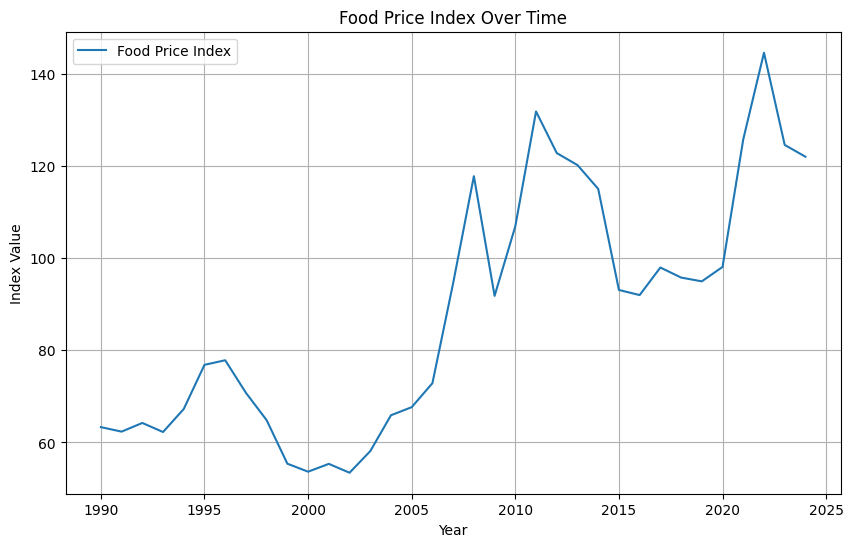

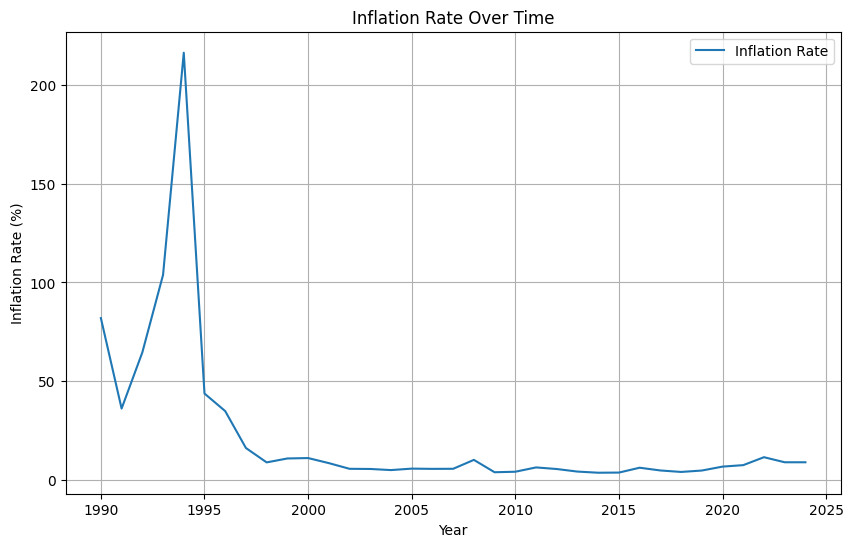

In [ ]:
# Plot Food Price Index
plt.figure(figsize=(10, 6))
plt.plot(fpi_inflation_merged["Year"], fpi_inflation_merged["Food Price Index"], label="Food Price Index")
plt.xlabel("Year")
plt.ylabel("Index Value")
plt.title("Food Price Index Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Inflation Rate
plt.figure(figsize=(10, 6))
plt.plot(fpi_inflation_merged["Year"], fpi_inflation_merged["Inflation Rate"], label="Inflation Rate")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.title("Inflation Rate Over Time")
plt.legend()
plt.grid(True)
plt.show()


## Data Contains Food Prices Inflation Rate over the years **2002 to 2024**

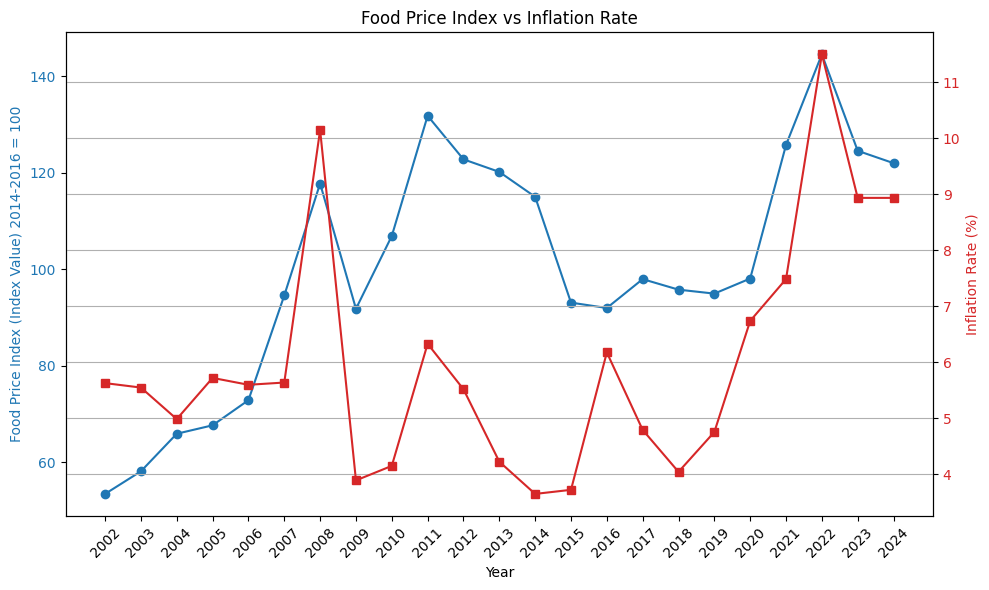

In [ ]:
# Filter data for years 2002 to 2024
fpi_inflation_merged_filtered = fpi_inflation_merged[(fpi_inflation_merged["Year"] >= 2002) & (fpi_inflation_merged["Year"] <= 2024)]

# Now fpi_inflation_merged_filtered contains data only from 2002 to 2024

# Plotting the dual y-axis chart using your existing DataFrame
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis: Food Price Index
ax1.set_xlabel('Year')
ax1.set_ylabel('Food Price Index (Index Value) 2014-2016 = 100', color='tab:blue')
ax1.plot(fpi_inflation_merged_filtered['Year'], fpi_inflation_merged_filtered['Food Price Index'],
         color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(fpi_inflation_merged_filtered['Year'])
ax1.set_xticklabels(fpi_inflation_merged_filtered['Year'].astype(int), rotation=45)

# Second y-axis: Inflation Rate
ax2 = ax1.twinx()
ax2.set_ylabel('Inflation Rate (%)', color='tab:red')
ax2.plot(fpi_inflation_merged_filtered['Year'], fpi_inflation_merged_filtered['Inflation Rate'],
         color='tab:red', marker='s')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and formatting
plt.title('Food Price Index vs Inflation Rate')
fig.tight_layout()
plt.grid(True)
plt.show()

# 📈 Food Price Index vs Inflation Rate (2002–2024)

This chart compares the **Food Price Index (FPI)** and the **Inflation Rate (%)** over time, offering insights into how food costs relate to overall inflation in the U.S. economy.

---

## 🔹 Left Y-Axis (Blue Line): Food Price Index (FPI)
- Measures the **cost of a representative basket of food items**.
- General **upward trend** from 2002 to 2024.
- **Notable spikes**:
  - **2007–2008**: Possibly due to global food price crisis.
  - **2010–2011**: Another period of commodity price inflation.
  - **2020–2022**: COVID-19 aftermath, supply chain disruptions.
- **Dips** in **2009** and **2015–2017**, possibly due to economic corrections.

---

## 🔹 Right Y-Axis (Red Line): Inflation Rate (%)
- Represents **economy-wide inflation**.
- **Stable (2002–2007)**: Ranging between 5–7%.
- **Spike in 2008**: Global financial crisis.
- **Drop in 2009**, followed by fluctuations.
- **Surge in 2021–2022**, peaking around **11%**, likely due to:
  - Pandemic-related stimulus
  - Energy shocks
  - Labor shortages
  - Russia-Ukraine war

---

## 🔍 Interpretation & Insights
- **Correlation**: FPI and inflation tend to **rise together during economic crises**.
- **Lag Effect**: Food prices may respond to broader inflation with a **slight delay**.
- **Sticky Prices**: Post-2022, while inflation cooled, **food prices remained high**, indicating that food price declines are slower than increases.

---


Even though the inflation has cooled down the food prices took time to come back to normal

## Analyzing the trends between Food Price Index and Producer Price Index ps2

In [ ]:
!wget https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/producer_price_index.csv -O producer_price_index.csv
ppi_df = pd.read_csv('producer_price_index.csv')
print(ppi_df.head(5))

--2025-04-29 03:54:34--  https://raw.githubusercontent.com/sg2083/datman/refs/heads/main/producer_price_index.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898634 (878K) [text/plain]
Saving to: ‘producer_price_index.csv’

producer_price_inde 100%[===================>] 877.57K  --.-KB/s    in 0.06s   

2025-04-29 03:54:35 (15.5 MB/s) - ‘producer_price_index.csv’ saved [898634/898634]

  Domain Code           Domain  Area Code (M49)         Area  Element Code  \
0          PP  Producer Prices                4  Afghanistan          5539   
1          PP  Producer Prices                4  Afghanistan          5539   
2          PP  Producer Prices                4  Afghanistan          5539   
3          PP  Producer Prices                4  Afghanistan   

In [ ]:
# Select only relevant columns
ppi_data_df = ppi_df[["Area", "Year", "Value"]]

# Rename columns for consistency
ppi_data_df.rename(columns={"Area": "Country", "Value": "PPI Value"}, inplace=True)

# Convert Year to integer and remove NaN values
ppi_data_df["Year"] = pd.to_numeric(ppi_data_df["Year"], errors="coerce")
ppi_data_df.dropna(inplace=True)

# Compute global PPI for each year
global_ppi_df = ppi_data_df.groupby("Year")["PPI Value"].mean().reset_index()

# Rename the column for clarity
global_ppi_df.rename(columns={"PPI Value": "Global PPI"}, inplace=True)

print(global_ppi_df.head(5))

   Year  Global PPI
0  1991   36.508214
1  1992   36.286975
2  1993   37.567638
3  1994   39.463835
4  1995   42.531579


<ipython-input-101-33fccfa1a646>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-101-33fccfa1a646>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-101-33fccfa1a646>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Outer merge
# Merge the two dataframes
merged_df = fpi_inflation_merged.merge( global_ppi_df, on='Year', how='outer', indicator=True)

# Print the merged dataframe
merged_df.head(5)


,Year,Food Price Index,Meat,Dairy,Cereals,Oils,Sugars,Inflation Rate,Global PPI,_merge
0,1990,63.317606,82.453911,42.621158,58.079751,45.469775,77.687305,81.935950,NaN,left_only
1,1991,62.345284,81.474667,45.460326,57.86382,49.007954,55.480618,36.127458,36.508214,both
2,1992,64.225559,78.387289,54.801593,60.957651,52.991996,56.042747,64.545737,36.286975,both
3,1993,62.259405,75.014033,48.616516,59.018588,53.966481,62.030198,103.783600,37.567638,both
4,1994,67.260547,76.297102,47.420202,61.936824,71.867754,74.943701,216.280994,39.463835,both


In [ ]:
# Merge global PPI with FPI & inflation data
fpi_ppi_merged_df = fpi_inflation_merged.merge(global_ppi_df, on="Year", how="left")

# Confirm which years have missing PPI
print("\nMissing PPI years before fixing:\n", fpi_ppi_merged_df[fpi_ppi_merged_df["Global PPI"].isna()])

# Ensure the dataset is sorted by Year before filling
fpi_ppi_merged_df = fpi_ppi_merged_df.sort_values("Year")

# Fill missing PPI for 1990 (using forward-fill method from 1991)
fpi_ppi_merged_df["Global PPI"] = fpi_ppi_merged_df["Global PPI"].fillna(method="bfill")

print("\nAfter filling missing value:\n", fpi_ppi_merged_df.head(5))

# Save the merged dataset
fpi_ppi_merged_df.to_csv("merged_fpi_ppi_inflation_.csv", index=False)
print("FPI - PPI merged dataset saved successfully!")



Missing PPI years before fixing:
    Year Food Price Index       Meat      Dairy    Cereals       Oils  \
0  1990        63.317606  82.453911  42.621158  58.079751  45.469775   

      Sugars  Inflation Rate  Global PPI  
0  77.687305        81.93595         NaN  

After filling missing value:
    Year Food Price Index       Meat      Dairy    Cereals       Oils  \
0  1990        63.317606  82.453911  42.621158  58.079751  45.469775   
1  1991        62.345284  81.474667  45.460326   57.86382  49.007954   
2  1992        64.225559  78.387289  54.801593  60.957651  52.991996   
3  1993        62.259405  75.014033  48.616516  59.018588  53.966481   
4  1994        67.260547  76.297102  47.420202  61.936824  71.867754   

      Sugars  Inflation Rate  Global PPI  
0  77.687305       81.935950   36.508214  
1  55.480618       36.127458   36.508214  
2  56.042747       64.545737   36.286975  
3  62.030198      103.783600   37.567638  
4  74.943701      216.280994   39.463835  
FPI - PPI me

<ipython-input-103-7f035746c824>:11: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



### Mapping/Recode: Categorizing Inflation Rates
Inflation rates vary significantly across years. Categorizing them into bins allows for an easier comparison of food price index trends under different inflation conditions.

The inflation rates have been categorized into 4 different bins(0,5,10,20) and into 4 different labels - "Low", "Moderate", "High" and "Very High"

These categories help in identifying patterns of food price index behavior under different inflationary pressures.

- Low inflation generally indicates stable economies with controlled price increases.
- Moderate inflation represents standard economic growth levels.
- High and Very High inflation often lead to economic instability, directly impacting food prices.

   Year Food Price Index       Meat      Dairy    Cereals       Oils  \
0  1990        63.317606  82.453911  42.621158  58.079751  45.469775   
1  1991        62.345284  81.474667  45.460326   57.86382  49.007954   
2  1992        64.225559  78.387289  54.801593  60.957651  52.991996   
3  1993        62.259405  75.014033  48.616516  59.018588  53.966481   
4  1994        67.260547  76.297102  47.420202  61.936824  71.867754   

      Sugars  Inflation Rate  Global PPI Inflation Category  
0  77.687305       81.935950   36.508214          Very High  
1  55.480618       36.127458   36.508214          Very High  
2  56.042747       64.545737   36.286975          Very High  
3  62.030198      103.783600   37.567638          Very High  
4  74.943701      216.280994   39.463835          Very High  


<ipython-input-104-b0e1dabb6523>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




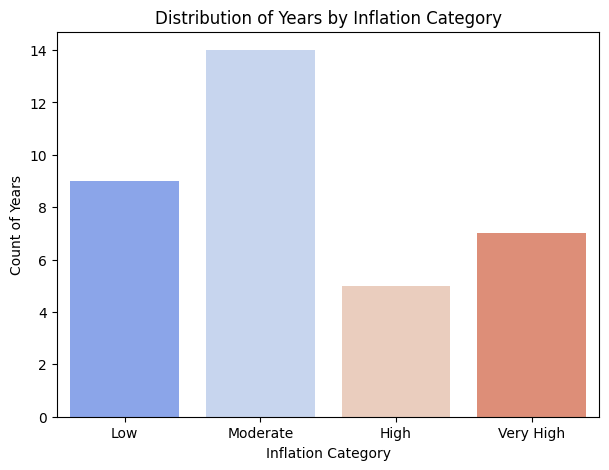

In [ ]:
# Map/recode: Categorizing inflation rates into bins for easier analysis
bins = [0, 5, 10, 20, float("inf")]
labels = ["Low", "Moderate", "High", "Very High"]
fpi_ppi_merged_df["Inflation Category"] = pd.cut(fpi_ppi_merged_df["Inflation Rate"], bins=bins, labels=labels)

print(fpi_ppi_merged_df.head(5))

# Count of Years in Each Inflation Category (Map/Recode Visualization)
plt.figure(figsize=(7, 5))
sns.countplot(data=fpi_ppi_merged_df, x="Inflation Category", palette="coolwarm")
plt.title("Distribution of Years by Inflation Category")
plt.xlabel("Inflation Category")
plt.ylabel("Count of Years")
plt.show()

### Replace on Condition

Instead of just analyzing the absolute FPI values, we flagged years where FPI was in the top 25%. This helps us understand whether food prices were abnormally high in certain economic conditions.

The High FPI column flags years where the Food Price Index (FPI) exceeds the 75th percentile. This helps identify years with exceptionally high food prices.

In [ ]:
# Replace on condition: Flagging years where food price index exceeds a threshold
fpi_ppi_merged_df["High FPI"] = fpi_ppi_merged_df["Food Price Index"].apply(lambda x: "Yes" if x > fpi_ppi_merged_df["Food Price Index"].quantile(0.75) else "No")

print(fpi_ppi_merged_df.head(5))

   Year Food Price Index       Meat      Dairy    Cereals       Oils  \
0  1990        63.317606  82.453911  42.621158  58.079751  45.469775   
1  1991        62.345284  81.474667  45.460326   57.86382  49.007954   
2  1992        64.225559  78.387289  54.801593  60.957651  52.991996   
3  1993        62.259405  75.014033  48.616516  59.018588  53.966481   
4  1994        67.260547  76.297102  47.420202  61.936824  71.867754   

      Sugars  Inflation Rate  Global PPI Inflation Category High FPI  
0  77.687305       81.935950   36.508214          Very High       No  
1  55.480618       36.127458   36.508214          Very High       No  
2  56.042747       64.545737   36.286975          Very High       No  
3  62.030198      103.783600   37.567638          Very High       No  
4  74.943701      216.280994   39.463835          Very High       No  


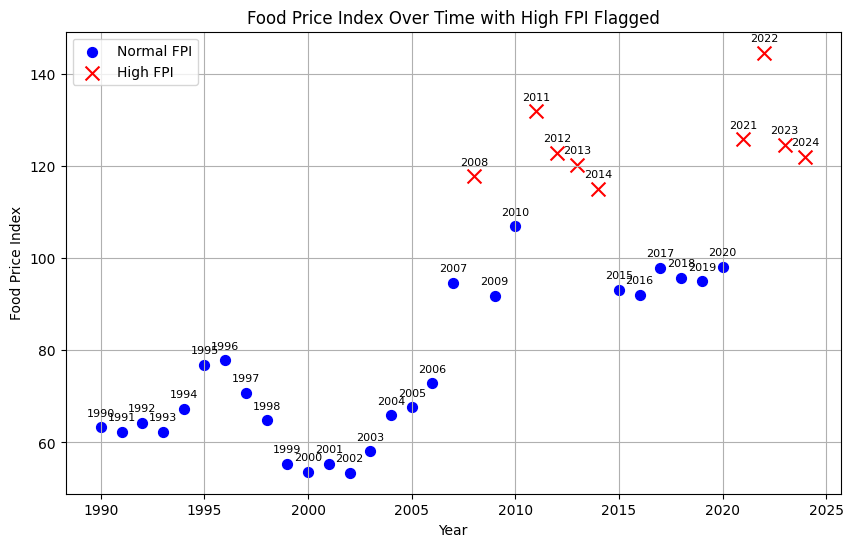

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
for index, row in fpi_ppi_merged_df.iterrows():
    if row['High FPI'] == 'Yes':
        plt.scatter(row['Year'], row['Food Price Index'], marker='x', color='red', s=100, label='High FPI' if index == fpi_ppi_merged_df[fpi_ppi_merged_df['High FPI'] == 'Yes'].index[0] else "")
        plt.text(row['Year'], row['Food Price Index'] + 2, str(int(row['Year'])), ha='center', va='bottom', fontsize=8)
    else:
        plt.scatter(row['Year'], row['Food Price Index'], marker='o', color='blue', s=50, label='Normal FPI' if index == fpi_ppi_merged_df[fpi_ppi_merged_df['High FPI'] == 'No'].index[0] else "")
        plt.text(row['Year'], row['Food Price Index'] + 2, str(int(row['Year'])), ha='center', va='bottom', fontsize=8)

# Customize the plot
plt.xlabel("Year")
plt.ylabel("Food Price Index")
plt.title("Food Price Index Over Time with High FPI Flagged")
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-107-71a4dcb09ba6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



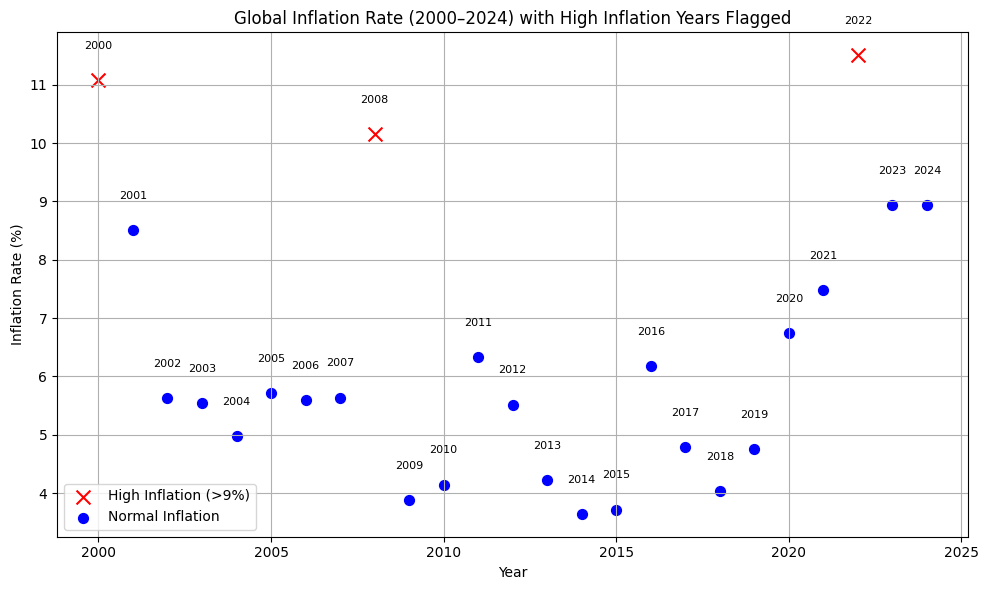

In [ ]:
# Filter data from 2000 to 2024
fpi_ppi_merged_df = fpi_ppi_merged_df[(fpi_ppi_merged_df['Year'] >= 2000) & (fpi_ppi_merged_df['Year'] <= 2024)]

# Create a new column to flag high inflation
fpi_ppi_merged_df['High Inflation'] = fpi_ppi_merged_df['Inflation Rate'] > 9

# Plot
plt.figure(figsize=(10, 6))
for index, row in fpi_ppi_merged_df.iterrows():
    if row['High Inflation']:
        plt.scatter(row['Year'], row['Inflation Rate'], marker='x', color='red', s=100,
                    label='High Inflation (>9%)' if index == fpi_ppi_merged_df[fpi_ppi_merged_df['High Inflation']].index[0] else "")
        plt.text(row['Year'], row['Inflation Rate'] + 0.5, str(int(row['Year'])), ha='center', va='bottom', fontsize=8)
    else:
        plt.scatter(row['Year'], row['Inflation Rate'], marker='o', color='blue', s=50,
                    label='Normal Inflation' if index == fpi_ppi_merged_df[~fpi_ppi_merged_df['High Inflation']].index[0] else "")
        plt.text(row['Year'], row['Inflation Rate'] + 0.5, str(int(row['Year'])), ha='center', va='bottom', fontsize=8)

# Customize the plot
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.title("Global Inflation Rate (2000–2024) with High Inflation Years Flagged")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Subsetting/Slicing: Analyzing the Last 10 Years

The food and inflation landscape changes over time. By focusing on the last 10 years, we can analyze recent trends without older data skewing our insights. This could provide a different view on our analysis.

Inflation rates have risen significantly over the last 10 years, with most years in the Very High category.
FPI has steadily increased, meaning global food prices have been inflationary.

In [ ]:
# Subset/Slice: Extracting data for the last 10 years for focused analysis
recent_data = fpi_ppi_merged_df[fpi_ppi_merged_df["Year"] >= fpi_ppi_merged_df["Year"].max() - 10]

print(recent_data.head(5))

    Year Food Price Index        Meat       Dairy     Cereals        Oils  \
24  2014        114.98315  112.110174  130.206524  115.818291  110.616261   
25  2015        93.063813   96.782797   87.145149    95.87342   89.941094   
26  2016        91.953037   91.107028   82.648327   88.308289   99.442644   
27  2017        97.932547   97.471031  108.011272   90.984263  101.909476   
28  2018        95.751774    94.39851  107.271688   100.82233   87.761077   

        Sugars  Inflation Rate  Global PPI Inflation Category High FPI  \
24  105.195389        3.645941   98.020189                Low      Yes   
25   83.181185        3.719073   98.951118                Low       No   
26  111.623426        6.175018  102.032050           Moderate       No   
27   99.112204        4.790194  106.240497                Low       No   
28   77.402053        4.040265  110.487764                Low       No   

    High Inflation  
24           False  
25           False  
26           False  
27      

### Aggregation: Finding Average FPI and Inflation per Inflation Category

Grouping data by Inflation Category helps us quantify how food prices behave under different economic conditions.

The groupby operation calculates the average Food Price Index (FPI) and Inflation Rate for each Inflation Category (Low, Moderate, High, Very High).

In [ ]:
# Groupby/Aggregation: Average FPI and inflation rate per inflation category
category_agg = fpi_ppi_merged_df.groupby("Inflation Category")[["Food Price Index", "Inflation Rate"]].mean().reset_index()
print("Aggregated data by Inflation Category:\n", category_agg)

Aggregated data by Inflation Category:
   Inflation Category Food Price Index  Inflation Rate
0                Low        97.929758        4.243159
1           Moderate        93.745915        6.673643
2               High       105.301998       10.908692
3          Very High              NaN             NaN


<ipython-input-109-3745f2d2877f>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



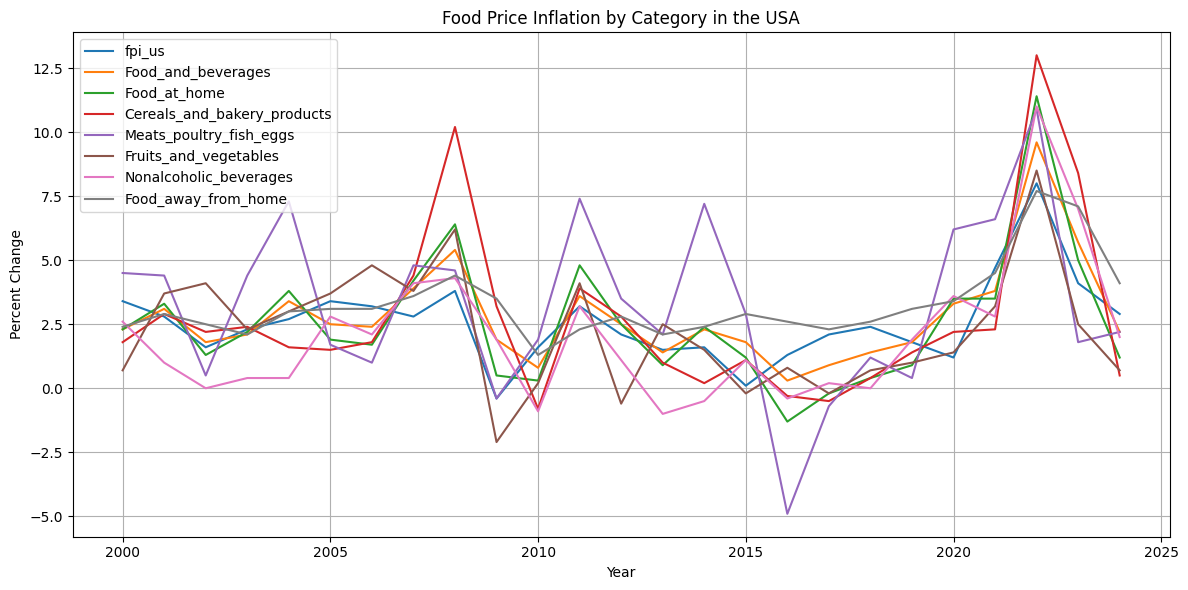

In [ ]:
# Set year as index or x-axis
fpi_us_with_catogaries_changeper.set_index("Year", inplace=True)

# Plot
plt.figure(figsize=(12, 6))
for column in fpi_us_with_catogaries_changeper.columns:
    plt.plot(fpi_us_with_catogaries_changeper.index, fpi_us_with_catogaries_changeper[column], label=column)

plt.title("Food Price Inflation by Category in the USA")
plt.xlabel("Year")
plt.ylabel("Percent Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

\# 📊 Graph: Food Price Inflation by Category in the USA (2000–2024)

Each line represents the percent change in prices (YoY inflation) for different food categories.  
The **x-axis** is the **year** and **y-axis** is the **percentage change in price**.

---

## 🔍 Key Insights from the Graph:

### ✅ 1. Spike in 2022–2023
- The sharpest inflation across almost all categories occurred in 2022.
- **Cereals and bakery products** hit a peak inflation rate of **over 13%**—the highest among all categories.
- **Meats**, **dairy**, **nonalcoholic beverages**, and **food at home** all experienced significant jumps.

### ✅ 2. Post-2008 Spike
- Around **2008–2009**, some categories like **cereals** and **meat** also showed noticeable inflation.
- Likely linked to the **global financial crisis** and **commodity price shocks**.

### ✅ 3. Volatility in Meats & Nonalcoholic Beverages
- The line for **Meats, Poultry, Fish, Eggs** shows **frequent and large fluctuations** → highly volatile.
- **Nonalcoholic beverages** also show inconsistent patterns with sudden drops and rises.

### ✅ 4. Consistent Growth in Food Away From Home
- This line shows **steady growth** with fewer drops.
- Makes sense as **eating out steadily becomes more expensive** due to **labor, rent, and service costs**.

### ✅ 5. 2023 Drop
- After peaking in 2022, **most categories show a drop** in inflation in 2023.
- Suggests **easing price pressure**—but still **elevated compared to earlier years**.

### ✅ 6. Breadth of Impact
- The spike in 2022 wasn’t just one or two categories—it affected **nearly all of them**.
- That’s rare and signals a **broad inflationary event**, likely due to:
  - **COVID-era supply chain issues**
  - **War in Ukraine affecting grain and oil**
  - **Global fuel price shocks**

---

## 🧠 Conclusions:
- "Cereal-based items are most sensitive to global commodity shocks."
- "The inflation in food-away-from-home is more structural than cyclical."
- "The 2022 inflation event was systemic, not isolated to any one food group."


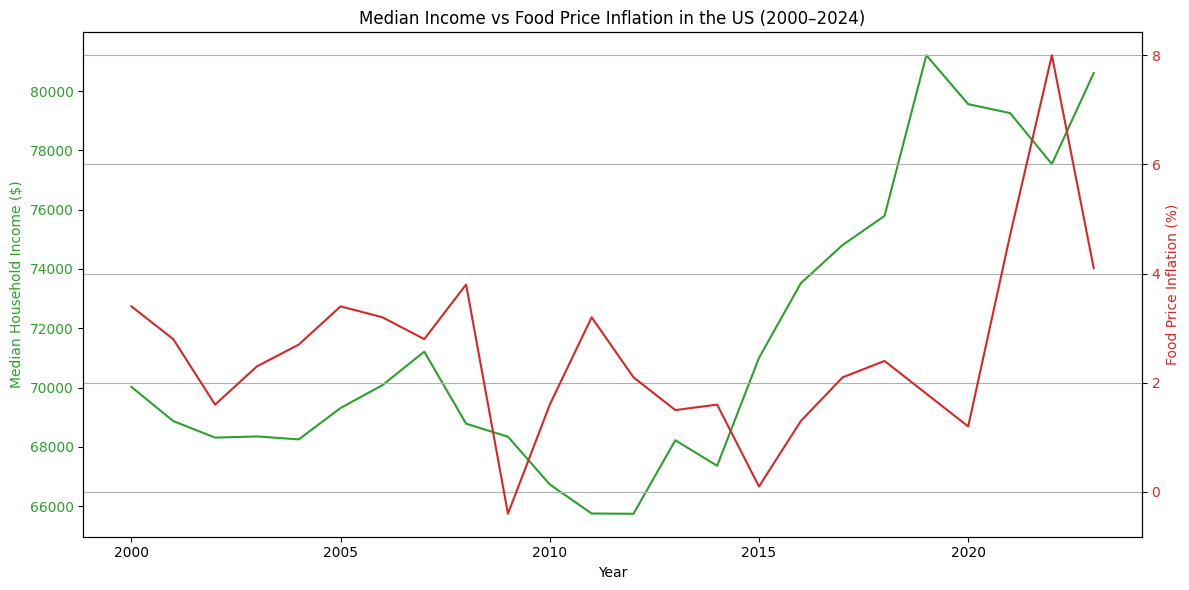

In [ ]:
# Merge on Year
merged_fpi_income = pd.merge(fpi_us_with_catogaries_changeper, median_household_income_us, on='Year', how='inner')
# Create Affordability Index (higher = more affordable)
merged_fpi_income['Affordability_Index'] = merged_fpi_income['median_income_us'] / merged_fpi_income['fpi_us']
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Median Income on left axis
color = 'tab:green'
ax1.set_xlabel('Year')
ax1.set_ylabel('Median Household Income ($)', color=color)
ax1.plot(merged_fpi_income['Year'], merged_fpi_income['median_income_us'], color=color, label='Median Household Income')
ax1.tick_params(axis='y', labelcolor=color)

# Create right axis for FPI
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Food Price Inflation (%)', color=color)
ax2.plot(merged_fpi_income['Year'], merged_fpi_income['fpi_us'], color=color, label='Food Price Inflation (FPI)')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title("Median Income vs Food Price Inflation in the US (2000–2024)")
fig.tight_layout()
plt.grid(True)
plt.show()

| Observation             | Details |
|--------------------------|---------|
| 2000–2008                | Median income remained mostly flat or slightly declining, while food inflation was moderate (2–3%). |
| 2008–2010 (Great Recession) | 📉 Food inflation spiked briefly (~4%), while median income dropped sharply. |
| 2010–2015                | Recovery period — median income stagnant or slightly recovering; food inflation relatively low and volatile (0–2%). |
| 2015–2019                | 📈 Median income started to rise steadily (~$66K → $78K), while food inflation remained moderate (1–2%). |
| 2020–2022 (COVID Shock)  | 🚨 Huge spike in food inflation (~up to 8%) while median income temporarily flattened or dropped. |
| 2023–2024                | 📉 Food inflation cooling slightly, but median income rebounding towards $81K+. |


In [ ]:
average_actual_price_data = pd.read_csv('bls_average_price_data.csv')

# Convert 'Month' column to datetime
average_actual_price_data['Month'] = pd.to_datetime(average_actual_price_data['Month'])
# Set as index for resampling
average_actual_price_data.set_index('Month', inplace=True)

# Resample to annual mean (per food item)
annual_prices = average_actual_price_data.resample('Y').mean().reset_index()

# Extract year from date
annual_prices['Year'] = annual_prices['Month'].dt.year

# Move 'Year' to the front
cols = ['Year'] + [col for col in annual_prices.columns if col != 'Year' and col != 'Month']
annual_prices = annual_prices[cols]

# Show result
annual_prices.head()

<ipython-input-112-8d0c10b6bf49>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-112-8d0c10b6bf49>:9: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



,Year,"Bananas, per lb.","Oranges, Navel, per lb.","Bread, white, pan, per lb.","Tomatoes, field grown, per lb.","Chicken, fresh, whole, per lb.",Electricity per KWH,"Eggs, grade A, large, per doz.","Gasoline, unleaded regular, per gallon","Ground chuck, 100% beef, per lb.",Utility (piped) gas per therm,"Milk, fresh, whole, fortified, per gal."
0,2005,0.492167,0.995800,1.040333,1.611083,1.055750,0.100000,1.218167,2.295333,2.538500,1.251833,3.186833
1,2006,0.500333,1.087182,1.080500,1.731667,1.049333,0.112333,1.306250,2.588917,2.550250,1.281333,3.081333
2,2007,0.510167,1.284455,1.207333,1.646583,1.115167,0.116667,1.676250,2.800583,2.699667,1.264917,3.503250
3,2008,0.609333,1.116333,1.366417,1.744083,1.206917,0.123333,1.986500,3.266250,2.873500,1.443750,3.795333
4,2009,0.611167,1.050417,1.387417,1.622750,1.278167,0.127167,1.664000,2.350167,2.877833,1.120833,3.109000


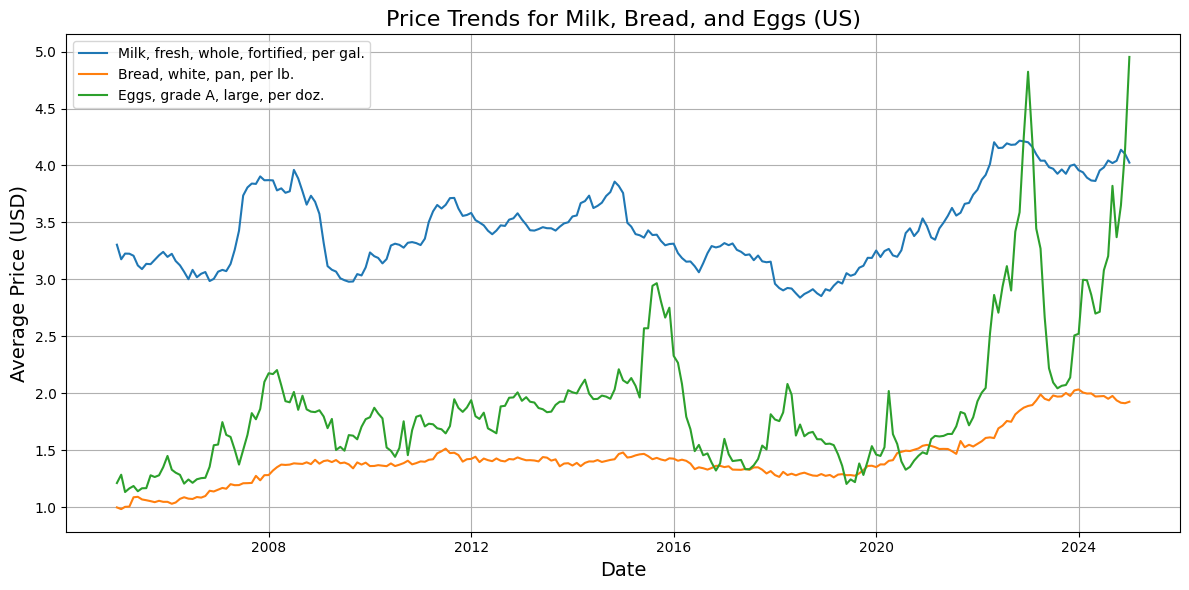

In [ ]:
selected_items = ['Milk, fresh, whole, fortified, per gal.',
                  'Bread, white, pan, per lb.',
                  'Eggs, grade A, large, per doz.']

# Filter and plot
plt.figure(figsize=(12, 6))
for item in selected_items:
    plt.plot(average_actual_price_data.index,
             average_actual_price_data[item],
             label=item)

plt.title('Price Trends for Milk, Bread, and Eggs (US)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Price (USD)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Interpretation: Price Trends for Milk, Bread, and Eggs (2006–2025)

## 🥛 Milk (blue line)
- Relatively stable between 2006 and 2018 with prices ranging between ~$3.0–$3.8 per gallon.
- A noticeable dip around 2009–2010 (post-recession) and again in 2016–2018.
- Sharp increase after 2021, peaking close to $4.2+ per gallon by 2023–2024.
- Suggests milk prices were heavily affected by recent inflation, likely due to supply chain and production cost pressures.

## 🍞 Bread (orange line)
- Shows a slow but steady increase over time, from ~$1.0/lb\ in -2006- to ~$2.0/lb in 2023.
- This category had low volatility, indicating stable pricing trends.
- Inflation affected it gradually, with no extreme price spikes like eggs or milk.

## 🥚 Eggs (green line)
- Highly volatile compared to milk and bread.
- Large price spikes in 2015, again in 2022, and a record peak in 2023–2024 (~$4.8/dozen).
- Likely linked to avian flu outbreaks, feed costs, and supply shortages.
- Egg prices are most sensitive to market shocks.

---

## 🔍 Key Insights
- 📈 **2022–2024 saw the steepest inflation** in all three items — consistent with post-COVID inflation surge.
- 🥚 **Eggs are the most volatile**, and thus a useful indicator of inflation stress.
- 🍞 **Bread is the most stable**, potentially due to government price supports, broad supply chain, or low perishability.
- 🥛 **Milk prices have gradually trended upward**, with inflation impact visible post-2020.


In [ ]:
annual_prices['Food_Basket'] = (
    annual_prices['Milk, fresh, whole, fortified, per gal.'] +
    annual_prices['Bread, white, pan, per lb.'] +
    annual_prices['Eggs, grade A, large, per doz.']
)

# Join with your median_income_us DataFrame on 'Year'
merged_afford_income = pd.merge(annual_prices[['Food_Basket','Year']], merged_fpi_income, on='Year')

# Affordability = Income / Basket
merged_afford_income['Affordability_Index'] = merged_afford_income['median_income_us'] / merged_afford_income['Food_Basket']

In [ ]:
merged_afford_income.head()


,Food_Basket,Year,fpi_us,Food_and_beverages,Food_at_home,Cereals_and_bakery_products,Meats_poultry_fish_eggs,Fruits_and_vegetables,Nonalcoholic_beverages,Food_away_from_home,median_income_us,Affordability_Index
0,5.445333,2005,3.4,2.5,1.9,1.5,1.7,3.7,2.8,3.1,69310,12728.330069
1,5.468083,2006,3.2,2.4,1.7,1.8,1.0,4.8,2.1,3.1,70080,12816.190926
2,6.386833,2007,2.8,3.9,4.2,4.4,4.8,3.8,4.1,3.6,71210,11149.500274
3,7.148250,2008,3.8,5.4,6.4,10.2,4.6,6.2,4.3,4.4,68780,9621.935439
4,6.160417,2009,-0.4,1.9,0.5,3.2,-0.4,-2.1,1.9,3.5,68340,11093.405479


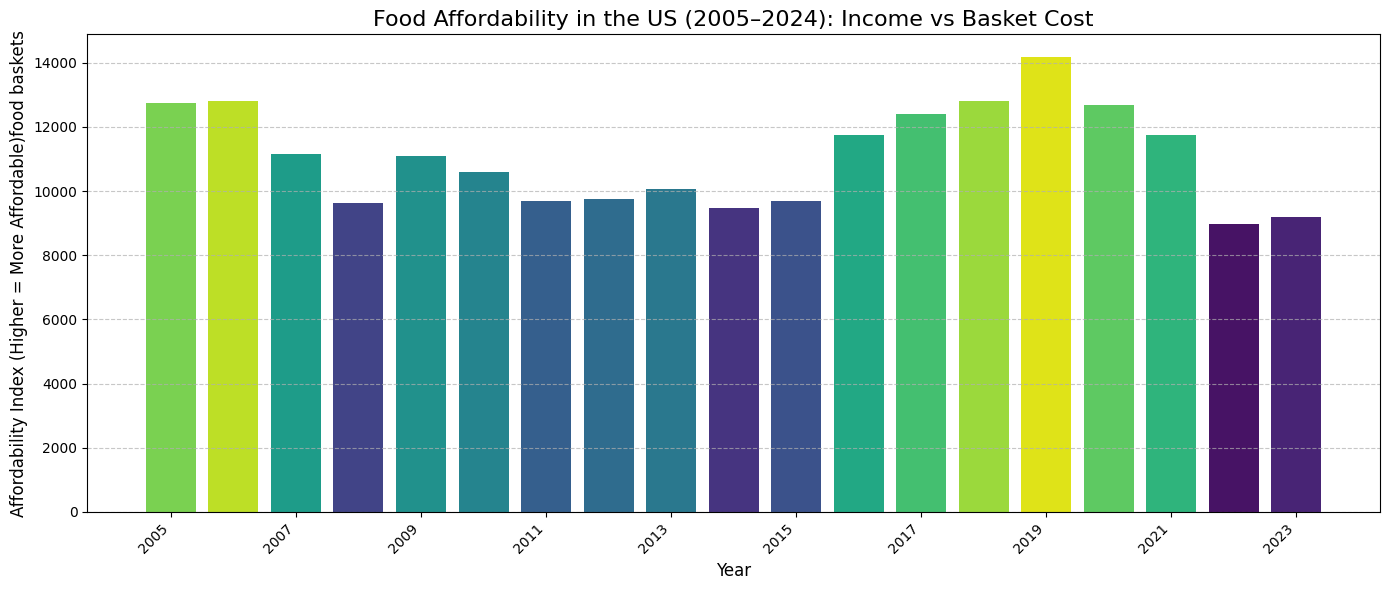

In [ ]:
colors = sns.color_palette("viridis", len(merged_afford_income))
color_values = pd.qcut(merged_afford_income['Affordability_Index'], q=len(colors), labels=False)

plt.figure(figsize=(14, 6))
plt.bar(merged_afford_income['Year'], merged_afford_income['Affordability_Index'], color=[colors[i] for i in color_values])
plt.title("Food Affordability in the US (2005–2024): Income vs Basket Cost", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Affordability Index (Higher = More Affordable)food baskets", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=merged_afford_income['Year'][::2], rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Affordability Index
Imagine a situation where the **median income** is 70,000 dollars, and the price of a **food basket** (containing essentials like milk, bread, and eggs) is $7.
The **Affordability Index** is calculated by dividing the income by the cost of the food basket:
```python
Affordability_Index = 70000 / 7 = 10,000
```
This result means that a person earning the median income could theoretically buy **10,000 food baskets** in a year.
In simple terms, food is very affordable because a large number of baskets can be purchased with the available income.

##📉 When Food Becomes More Expensive.<br>
Now, consider the price of the same food basket increases to \$14 while the median income stays the same at $70,000.
Recalculating the index:

```python
Affordability_Index = 70000 / 14 ≈ 5,000
````
This shows that the same person can now only afford about **5,000 food baskets** per year.
This means food has become **twice as expensive relative to their income**.
Thus, food affordability has dropped significantly, signaling that more income is needed to buy the same essential items.

# 📊 Graph Interpretation: Food Affordability Index (2005–2024)

---

## 🧮 What the Index Represents

**Affordability Index** = Median Household Income ÷ Food Basket Cost

- A higher bar (greener/brighter) = food is more affordable
- A lower bar (purple/darker) = food is less affordable

---

## 🔍 Key Observations

### ✅ Most Affordable Years
- **2018–2019** show the highest Affordability Index, with bars reaching the top of the chart and bright color (yellow-green).
- Indicates peak purchasing power: income was high, and food costs were relatively low.

### ⚖️ Stable Years
- **2005–2007** and **2016–2017** show moderate affordability with decent bars (green to teal).
- Suggests a balanced economy — not extreme inflation or wage stress.

### ❌ Least Affordable Years
- **2022–2024** show a sharp drop in affordability, indicated by dark purple bars.
- Reflects recent post-COVID inflation spikes, especially in food items like eggs and milk, while income didn’t keep pace.

### ⚠️ 2008–2015 Plateau
- Long period of stagnation with flat affordability (mostly navy-blue bars).
- Coincides with the aftermath of the 2008 recession where wages struggled, and food prices remained stubborn.

---



## Living Wage Vs Actual Income of the State

Literature

- **1912**: Massachusetts passed the first minimum wage law.
- **1938**: Congress created the **Fair Labor Standards Act**, setting a minimum wage at **25 cents/hour**.
- **1968**: U.S. minimum wage value peaked.
- **Early 1990s**: Minimum wage fell below poverty level. Congress resisted raising it.
- **1994**:  
  - **Baltimore, Maryland** launched the first **modern living wage campaign**.
  - Won a law for city contractors to pay **$7.25/hour**.
- **1994–2010**:  
  - Over **125 cities and counties** passed living wage ordinances.
  - Ordinances mainly helped workers on city contracts.
- **Challenges**:  
  - Wages set only at poverty line, not true cost of living.
  - Small number of workers were covered.

- **2004**:  
  - **San Francisco, Albuquerque, Santa Fe** passed citywide minimum wage laws.

- **2008**:  
  - Economic crash paused wage campaigns.

- **2011**:  
  - **Occupy Wall Street** protested inequality.
  - Inspired new energy around fighting for higher wages.

- **2012**:  
  - **Fast-food workers in New York City** went on strike, demanding **\$15/hour** and a union.
  - Start of the **Fight for $15** movement.

- **Late 2012**:  
  - **Sea-Tac, Washington** passed a $15/hour wage ballot initiative.

- **2013–2016**:  
  - Strikes happened in hundreds of cities.
  - Fight for $15 spread nationwide.

- **By 2017**:  
  - Over **40 cities and counties** raised minimum wages (between **\$8.50** to **\$16/hour**).
  - Many states also raised their minimum wages.

## Key Findings

- Early fears that higher wages would "kill jobs" were **mostly wrong**.
- Studies showed **no major job loss**, and some businesses even improved (lower turnover, happier workers).
- Some workers lost government benefits, but **most were better off**.

## Unique Features of U.S. Living Wage Movement

- Focused on **mandatory laws**, not just asking companies nicely.
- Built **big alliances**: unions, community groups, churches.
- Blurred line between "living wage" and "minimum wage" efforts.

## Challenges

- No clear formula for \$15/hour — it’s a bold, simple goal, not carefully calculated.
- $15/hour is enough in some cities but **too low in expensive cities**.
- Workers often **don’t get enough work hours**.
- **Unionizing** low-wage industries is still very hard.
- **Automation** (machines replacing workers) is a concern, but hasn’t happened yet in big numbers.

## Recent Victories

- **November 8, 2016**: Four new state wage increases passed by voters.
- **2012–2016**: Over **20 million workers** got raises, adding up to **$62 billion**.

## Future Outlook

- Focus will stay on **local and state levels**.
- Activists must avoid compromises that weaken workers’ rights.
- Building strong, broad **political alliances** is key to making bigger changes.

Living Wage

In [ ]:
# Used API to gather living wage data from the website.
# import requests
# from bs4 import BeautifulSoup

# wayback_urls = {
#     2015: "https://web.archive.org/web/20150614050638/https://livingwage.mit.edu/states",
#     2019: "https://web.archive.org/web/20191215035447/https://livingwage.mit.edu/states",
#     2022: "https://web.archive.org/web/20221010092652/https://livingwage.mit.edu/states",
#     2023: "https://livingwage.mit.edu/states"  # Current live site
# }

# # Storage
# all_years_data = []

# # Loop over years
# for year, url in wayback_urls.items():
#     print(f"Scraping {year} data...")

#     # Get main page
#     main_page = requests.get(url).text
#     soup = BeautifulSoup(main_page, "html.parser")

#     # Extract state links
#     state_links = [a['href'] for a in soup.select('div#content a') if '/states/' in a['href'] and len(a['href'].split('/')) == 3]

#     base_url = "https://web.archive.org" if year != 2023 else "https://livingwage.mit.edu"

#     # Loop through states
#     for link in state_links:
#         full_url = ("/web/" + url.split("/web/")[1].split("/https://")[0] + link) if year != 2023 else base_url + link
#         try:
#             state_page = requests.get(base_url + link).text if year == 2023 else requests.get("https://" + link.split("https://")[-1]).text
#             state_soup = BeautifulSoup(state_page, "html.parser")
#             state_name = link.split('/')[-1].replace('-', ' ').title()

#             # Find table
#             table = state_soup.find("table", {"id": "living-wage"})
#             rows = table.find_all("tr")

#             for row in rows:
#                 cols = [ele.text.strip() for ele in row.find_all('td')]
#                 if cols and cols[0] == '1 Adult' and cols[1] == '0 Children':
#                     living_wage = cols[2]
#                     living_wage = float(living_wage.replace('$', ''))
#                     all_years_data.append({
#                         "State": state_name,
#                         "Year": year,
#                         "Living_Wage": living_wage
#                     })
#                     break
#         except Exception as e:
#             print(f"Failed {state_name} in {year}: {e}")

# # Convert to DataFrame
# living_wage_all_years = pd.DataFrame(all_years_data)

# # Save
# living_wage_all_years.to_csv("living_wage_by_state_2008_2023.csv", index=False)

# # Preview
# print(living_wage_all_years.head())


In [ ]:
# Step 2: Standardize 'State' column
median_income_by_state['State'] = median_income_by_state['State'].str.strip().str.lower()
living_wage_by_state['State'] = living_wage_by_state['State'].str.strip().str.lower()
median_income_by_state = median_income_by_state.rename(columns={
    2008: '2008_Income',
    2011: '2011_Income',
    2015: '2015_Income'
})

living_wage_by_state = living_wage_by_state.rename(columns={
    '2015': '2015_LivingWage'
})
# Step 3: Merge datasets
merged_income_livingwage_df = pd.merge(median_income_by_state, living_wage_by_state, on='State', suffixes=('_Income', '_LivingWage'))
# Step 4: Calculate Affordability Ratios for each year
for year in [2015, 2019, 2022, 2023]:
    merged_income_livingwage_df[f'Affordability_Ratio_{year}'] = merged_income_livingwage_df[f'{year}_Income'] / (merged_income_livingwage_df[f'{year}_LivingWage']*2080)
    merged_income_livingwage_df[f'Affordability_Ratio_{year}'] = merged_income_livingwage_df[f'Affordability_Ratio_{year}'].round(2)

# Step 5: Make state names Proper Case again
merged_income_livingwage_df['State'] = merged_income_livingwage_df['State'].str.title()

# Step 6: Save the merged dataset
merged_income_livingwage_df.to_excel("State_Affordability_Ratios_2015_2023.xlsx", index=False)

# Optional: Show first few rows
merged_income_livingwage_df.head()

,State,2008_Income,2011_Income,2015_Income,2019_Income,2022_Income,2023_Income,2015_LivingWage,2019_LivingWage,2022_LivingWage,2023_LivingWage,Affordability_Ratio_2015,Affordability_Ratio_2019,Affordability_Ratio_2022,Affordability_Ratio_2023
0,Alabama,60810,55940,55920,66430,62290,60660,10.17,11.95,13.5,14.1,2.64,2.67,2.22,2.07
1,Alaska,87500,75440,94360,92670,93310,98190,11.17,13.32,15.6,16.2,4.06,3.34,2.88,2.91
2,Arizona,64150,63860,65640,83540,76370,82660,10.47,12.09,14.2,15.0,3.01,3.32,2.59,2.65
3,Arkansas,54130,54250,53770,64470,56120,63250,9.56,11.30,13.1,13.8,2.70,2.74,2.06,2.20
4,California,77960,70100,79940,92330,88690,89870,12.34,14.00,16.5,17.2,3.11,3.17,2.58,2.51


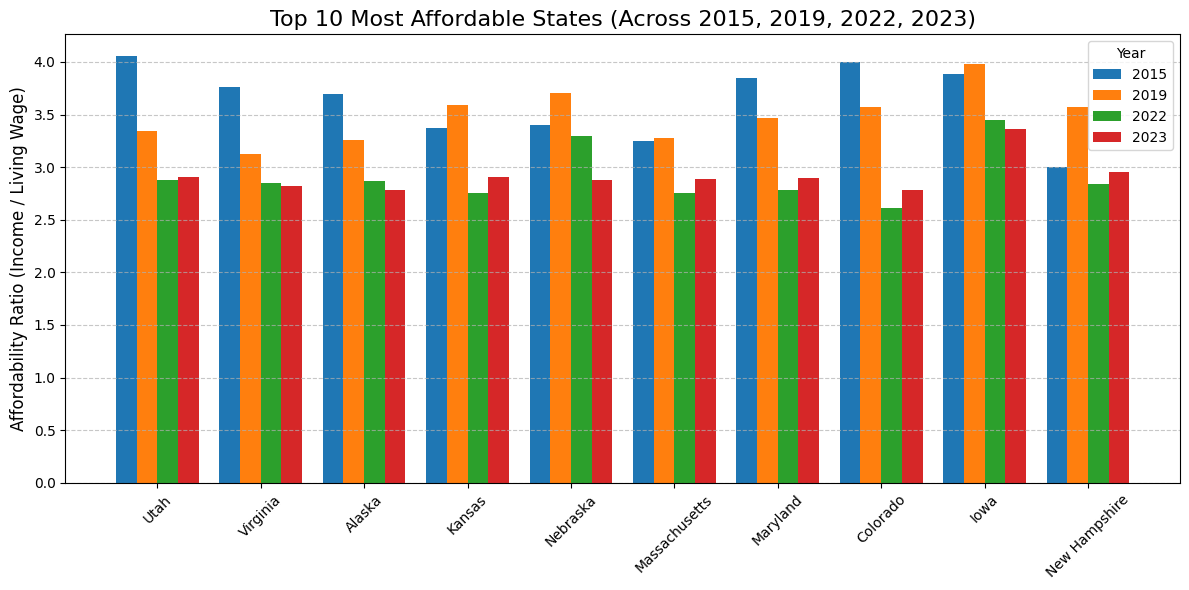

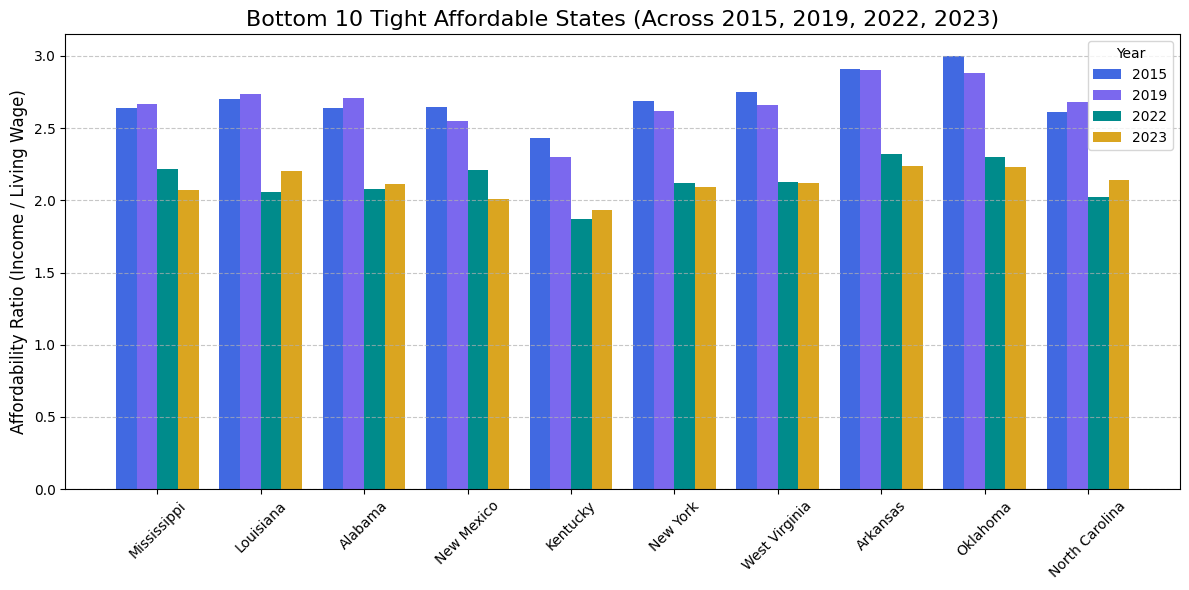

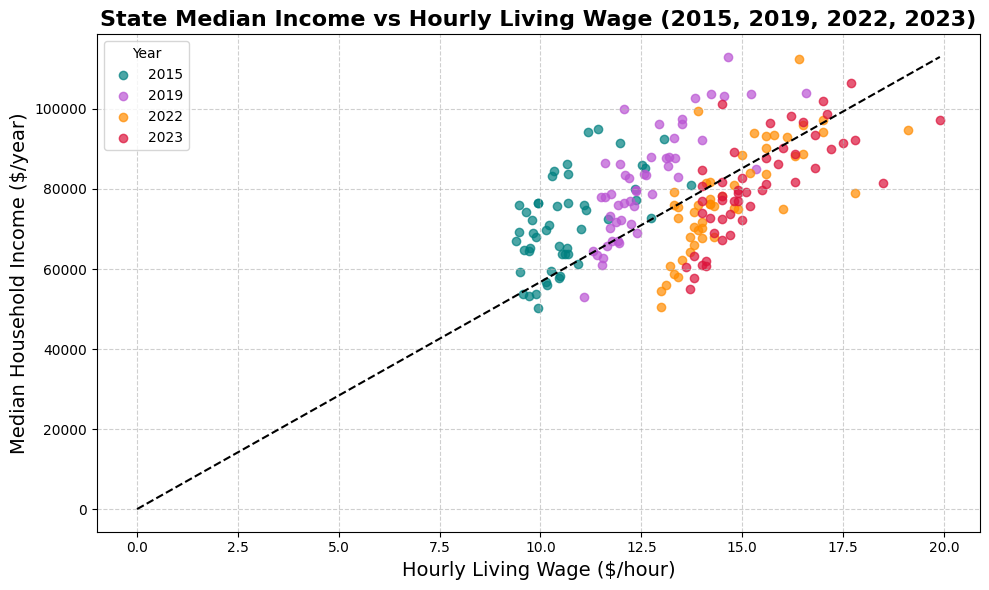

In [ ]:
# Select year to analyze

years= [2015, 2019, 2022, 2023]
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District Of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Apply mapping
merged_income_livingwage_df['State_Code'] = merged_income_livingwage_df['State'].map(state_abbrev)

selected_year = 2023
animation_df = pd.DataFrame()

# Define your affordability categorization function again
def categorize_affordability(ratio):
    if ratio > 3.2:
        return 'Very High Affordability'
    elif 2.5 < ratio <= 3.2:
        return 'Good Affordability'
    elif 1.2 < ratio <= 2.5:
        return 'Tight Affordability'
    elif 0.9 < ratio <= 1.2:
        return 'Barely Affordable'
    else:
        return 'Unaffordable'

# Expand data across years
for year in years:
    temp = merged_income_livingwage_df[['State', 'State_Code', f'Affordability_Ratio_{year}']].copy()
    temp = temp.rename(columns={f'Affordability_Ratio_{year}': 'Affordability_Ratio'})
    temp['Year'] = year
    temp['Affordability_Category'] = temp['Affordability_Ratio'].apply(categorize_affordability)
    animation_df = pd.concat([animation_df, temp], axis=0)

# Define your custom color map
color_map = {
    'Very High Affordability': 'darkgreen',
    'Good Affordability': 'lightgreen',
    'Tight Affordability': 'yellow',
    'Barely Affordable': 'orange',
    'Unaffordable': 'red'
}

# Create the animated map
fig = px.choropleth(
    animation_df,
    locations="State_Code",  # Now using 2-letter state codes!
    locationmode="USA-states",
    color="Affordability_Category",
    color_discrete_map=color_map,
    scope="usa",
    animation_frame="Year",
    title="Animated US Map: Affordability Tiers by State (2015–2023)",
    category_orders={"Year": [2015, 2019, 2022, 2023]}
)

# Show the animated figure
fig.show()

# ------------------------
# 2. Top 10 and Bottom 10 States with Annotations
# ------------------------

selected_year = 2023
top_10_states = merged_income_livingwage_df.nlargest(10, f'Affordability_Ratio_{selected_year}')['State']

# Prepare the dataset for Top 10 across all years
top_10_data = merged_income_livingwage_df[merged_income_livingwage_df['State'].isin(top_10_states)]

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# X axis: states
x = np.arange(len(top_10_states))  # Number of states
width = 0.2  # Width of each bar

# Plot each year
for idx, year in enumerate(years):
    ax.bar(x + idx*width,
           top_10_data[f'Affordability_Ratio_{year}'],
           width=width,
           label=str(year))

# Set the labels and title
ax.set_ylabel('Affordability Ratio (Income / Living Wage)', fontsize=12)
ax.set_title('Top 10 Most Affordable States (Across 2015, 2019, 2022, 2023)', fontsize=16)
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(top_10_states, rotation=45)
ax.legend(title='Year')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Plot Bottom 10 Least Affordable States Across Years
colors = ['#4169e1', '#7b68ee', '#008b8b', '#daa520']  # Royal Blue, Medium Slate Blue, Dark Cyan, Goldenrod
bottom_10_states = merged_income_livingwage_df.nsmallest(10, f'Affordability_Ratio_{selected_year}')['State']
bottom_10_data = merged_income_livingwage_df[merged_income_livingwage_df['State'].isin(bottom_10_states)]

# Set up the figure
fig2, bx = plt.subplots(figsize=(12, 6))

# X axis: states
x = np.arange(len(bottom_10_data))  # Number of states
width = 0.2  # Width of each bar

# Plot each year
for idx, year in enumerate(years):
    bx.bar(x + idx*width,
           bottom_10_data[f'Affordability_Ratio_{year}'],
           width=width,
           color=colors[idx],
           label=str(year))

# Set the labels and title
bx.set_ylabel('Affordability Ratio (Income / Living Wage)', fontsize=12)
bx.set_title('Bottom 10 Tight Affordable States (Across 2015, 2019, 2022, 2023)', fontsize=16)
bx.set_xticks(x + width*1.5)
bx.set_xticklabels(bottom_10_states, rotation=45)
bx.legend(title='Year')
bx.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# ------------------------
# 3. Dot Plot: Income vs Living Wage with Labeling
# ------------------------
colors = ['#008080', '#BA55D3', '#FF8C00', '#DC143C']

# Set up figure
plt.figure(figsize=(10, 6))

texts = []

# Plot for each year
for idx, year in enumerate(years):
    plt.scatter(
        merged_income_livingwage_df[f'{year}_LivingWage'],
        merged_income_livingwage_df[f'{year}_Income'],
        c=colors[idx],
        label=str(year),
        alpha=0.7
    )

# Optional Reference Line (even though units differ)
plt.plot(
    [0, merged_income_livingwage_df[[f'{year}_LivingWage' for year in years]].max().max()],
    [0, merged_income_livingwage_df[[f'{year}_Income' for year in years]].max().max()],
    color='black',
    linestyle='--'
)

# Titles and labels
plt.title('State Median Income vs Hourly Living Wage (2015, 2019, 2022, 2023)', fontsize=16, fontweight='bold')
plt.xlabel('Hourly Living Wage ($/hour)', fontsize=14)
plt.ylabel('Median Household Income ($/year)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


# 🏠 Affordability Journey (2015 → 2023)

| Year | Overall Status | Key Changes |
|:----:|:--------------:|:------------|
| 2015 | 🟢 Very Affordable | Most states in "Very High" or "Good" Affordability tiers |
| 2019 | 🟢 Still Affordable | Minor increase in "Tight Affordability" (especially South, West) |
| 2022 | 🟠 Affordability Deteriorates | Inflation impact: Housing and food costs spiked |
| 2023 | 🟡 Affordability Crisis | Widespread "Tight Affordability" across U.S. |

## 🗺️ Regional Observations

- 🟢 **Midwest**: Most resilient (Still shows strong affordability).
- 🟡 **South**: Sharpest shift into "Tight Affordability."
- 🟠 **West Coast & Florida**: High cost states deteriorated fastest.

## 📈 Trends

- Affordability decline accelerated after 2019.
- Income growth lagged behind rising living costs.
- Inflation (2021–2022) drove a clear national affordability squeeze.

## 🔥 Key Takeaways

- 🛑 **Affordability Crisis** is no longer isolated — it's nationwide.
- 🏃‍♂️ **Migration patterns** may shift (people moving to cheaper states).
- 🧩 **Policy interventions** (e.g., minimum wage hikes, affordable housing) will become crucial.


# 📋 Interpretation of Multi-Year Affordability Bar Graphs

- 🏡 **Top 10 states** remain affordable but lost **20–30%** of their affordability strength.
- 📉 **Bottom 10 states** fell sharply and are approaching **dangerous affordability levels** (below 2.0 ratios soon if trends continue).
- 💵 **Income growth alone** is not sufficient to preserve affordability in the face of **systemic cost increases** (housing, healthcare, food).
- 🌎 **Regional disparity** is increasing:
  - Coastal and Midwest states fare better.
  - Southern states struggle more.


# 📊 Cluster Movement and Affordability (2015 → 2023)

| Aspect | Observation |
|:------:|:-----------|
| 📊 **Cluster Movement** | Clusters move rightward over time → Living wage (cost of living) has increased between 2015–2023. |
| 🟠 **2015 Cluster (Teal)** | Most states in 2015 had lower living wages (~$10–$12/hr) and incomes mostly well above the dashed line (healthy affordability). |
| 🟣 **2019 Cluster (Purple)** | Living wages rose slightly (~$12–$14/hr) but median incomes remained relatively strong — dots higher overall compared to 2015. |
| 🟠 **2022 Cluster (Orange)** | Clear shift: Living wages increased (~$13–$15/hr), but incomes flattened or dropped relative to the cost. Points are closer to the dashed line. |
| 🔴 **2023 Cluster (Red)** | Critical: Many states very close to or even below the dashed line — affordability crisis evident. |
| ⚠️ **Compression** | Spread of points tightens from 2015 → 2023 → States are becoming more similar in affordability struggles (less range between rich and poor states). |


#**Forecasting**


In [ ]:
# Filter data for years 2000 to 2023
fpi_inflation_merged_filtered = fpi_inflation_merged[
    (fpi_inflation_merged["Year"] >= 2000) & (fpi_inflation_merged["Year"] <= 2023)
]
fpi_inflation_merged_filtered = fpi_inflation_merged_filtered.rename(columns={'Food Price Index': 'Food_Price_Index'})
# Make sure Year columns are integers
fpi_inflation_merged_filtered['Year'] = fpi_inflation_merged_filtered['Year'].astype(int)
merged_fpi_income['Year'] = merged_fpi_income['Year'].astype(int)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplaikfbyi/roingpjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplaikfbyi/63kjvpk7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23404', 'data', 'file=/tmp/tmplaikfbyi/roingpjh.json', 'init=/tmp/tmplaikfbyi/63kjvpk7.json', 'output', 'file=/tmp/tmplaikfbyi/prophet_modeluebs1thc/prophet_model-20250429035445.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:54:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:

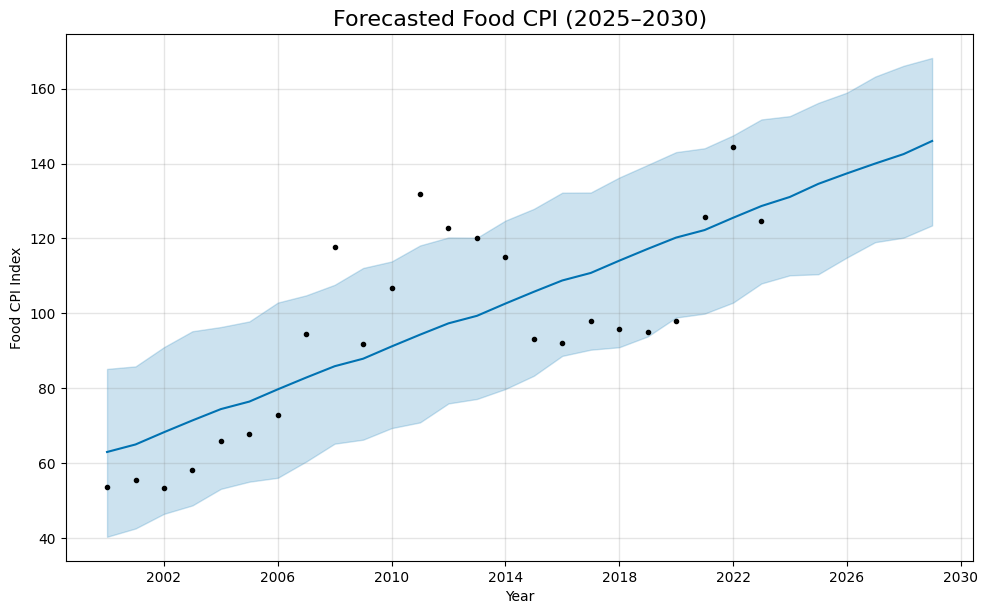

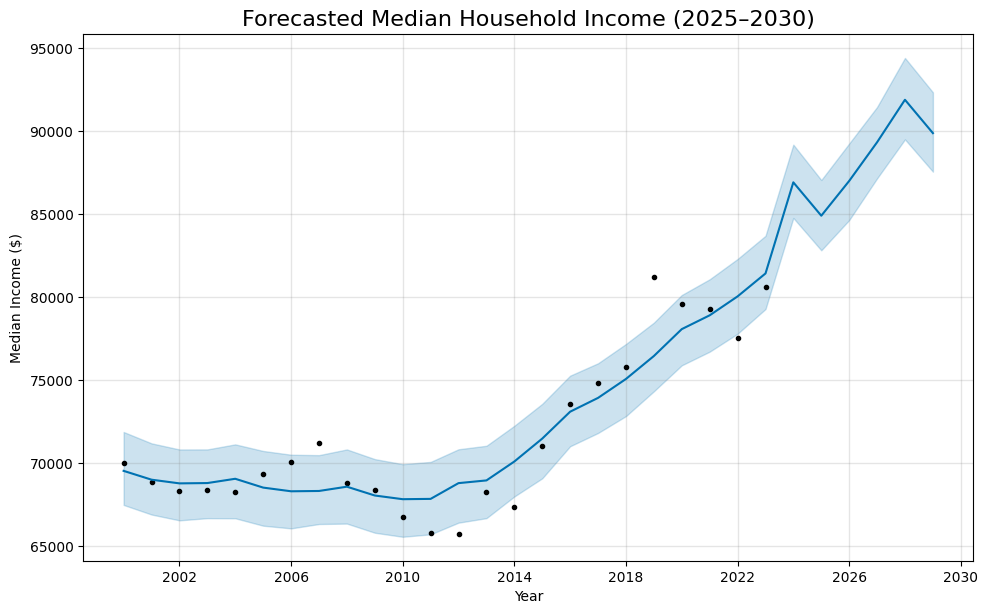

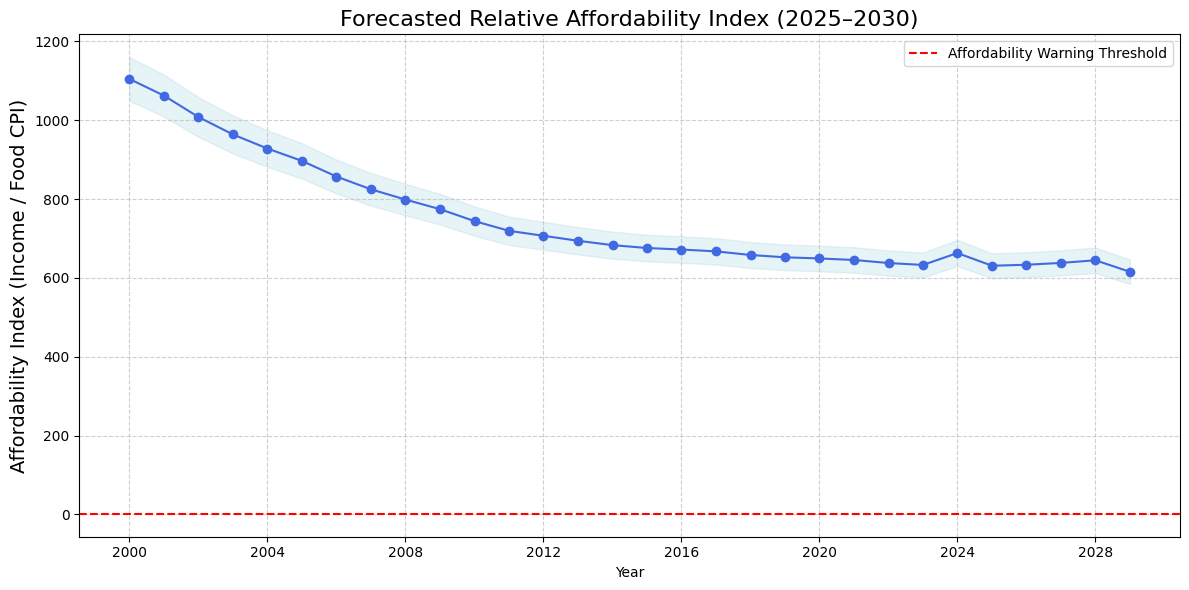

In [ ]:
# Correct date formatting
fpi_inflation_merged_filtered['ds'] = pd.to_datetime(fpi_inflation_merged_filtered['Year'], format='%Y')
merged_fpi_income['ds'] = pd.to_datetime(merged_fpi_income['Year'], format='%Y')

# Now select columns
food_cpi_df = fpi_inflation_merged_filtered[['ds', 'Food_Price_Index']].dropna().rename(columns={'Food_Price_Index': 'y'})
median_income_df = merged_fpi_income[['ds', 'median_income_us']].dropna().rename(columns={'median_income_us': 'y'})

# ----------------------
# 1. Food CPI Forecast
# ----------------------

food_cpi_model = Prophet()
food_cpi_model.fit(food_cpi_df)

# Make future dates
future_cpi = food_cpi_model.make_future_dataframe(periods=6, freq='Y')  # 6 years
forecast_cpi = food_cpi_model.predict(future_cpi)

# --------------------------------------------
# Step 3: Forecast Median Household Income (2025–2030)
# --------------------------------------------
income_model = Prophet()
income_model.fit(median_income_df)

future_income = income_model.make_future_dataframe(periods=6, freq='Y')
forecast_income = income_model.predict(future_income)

# --------------------------------------------
# Step 4: Merge Forecasts to Calculate Affordability Index
# --------------------------------------------
# Select the needed columns
forecast_cpi_trimmed = forecast_cpi[['ds', 'yhat']].rename(columns={'yhat': 'Food_CPI_Forecast'})
forecast_income_trimmed = forecast_income[['ds', 'yhat']].rename(columns={'yhat': 'Median_Income_Forecast'})

# Merge on 'ds' (Year)
affordability_forecast = pd.merge(forecast_cpi_trimmed, forecast_income_trimmed, on='ds')

# Calculate Relative Affordability Index
affordability_forecast['Affordability_Index'] = affordability_forecast['Median_Income_Forecast'] / affordability_forecast['Food_CPI_Forecast']

# --------------------------------------------
# Step 5: Plot Everything
# --------------------------------------------

# Plot 1: Food CPI Forecast
fig1 = food_cpi_model.plot(forecast_cpi)
plt.title('Forecasted Food CPI (2025–2030)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Food CPI Index')
plt.grid(True)
plt.show()

# Plot 2: Median Household Income Forecast
fig2 = income_model.plot(forecast_income)
plt.title('Forecasted Median Household Income (2025–2030)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Median Income ($)')
plt.grid(True)
plt.show()

# Plot 3: Relative Affordability Index Forecast
plt.figure(figsize=(12, 6))
plt.plot(affordability_forecast['ds'], affordability_forecast['Affordability_Index'], marker='o', color='royalblue')
plt.fill_between(affordability_forecast['ds'],
                 affordability_forecast['Affordability_Index']*0.95,
                 affordability_forecast['Affordability_Index']*1.05,
                 color='lightblue', alpha=0.3)  # Simulated confidence band

plt.title('Forecasted Relative Affordability Index (2025–2030)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Affordability Index (Income / Food CPI)', fontsize=14)
plt.axhline(y=1.5, color='red', linestyle='--', label='Affordability Warning Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
fpi_us_with_catogaries_changeper.columns


Index(['fpi_us', 'Food_and_beverages', 'Food_at_home',
       'Cereals_and_bakery_products', 'Meats_poultry_fish_eggs',
       'Fruits_and_vegetables', 'Nonalcoholic_beverages',
       'Food_away_from_home'],
      dtype='object')

In [ ]:
categories = [
    'Food_and_beverages',
    'Food_at_home',
    'Cereals_and_bakery_products',
    'Meats_poultry_fish_eggs',
    'Fruits_and_vegetables',
    'Nonalcoholic_beverages',
    'Food_away_from_home'
]

# --------------------------------------------
# Step 3: Forecast Each Category
# --------------------------------------------
forecast_results = {}
fpi_us_with_catogaries_changeper['ds'] = pd.to_datetime(fpi_us_with_catogaries_changeper.index, format='%Y')

for category in categories:
    # Prepare mini DataFrame
    category_df = fpi_us_with_catogaries_changeper[['ds', category]].dropna()
    category_df = category_df[['ds', category]].rename(columns={ category: 'y'})

    # Fit Prophet model
    model = Prophet()
    model.fit(category_df)

    # Create future dates
    future = model.make_future_dataframe(periods=6, freq='Y')  # Predict 2025–2030

    # Forecast
    forecast = model.predict(future)

    # Store result
    forecast_results[category] = (model, forecast)


print("✅ Finished forecasting all categories!")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplaikfbyi/47sysfr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplaikfbyi/pzcegp1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63347', 'data', 'file=/tmp/tmplaikfbyi/47sysfr6.json', 'init=/tmp/tmplaikfbyi/pzcegp1d.json', 'output', 'file=/tmp/tmplaikfbyi/prophet_modelrs5x5rgj/prophet_model-20250429035448.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:54:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:54:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:

✅ Finished forecasting all categories!


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



In [ ]:
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Build one trace per category (hidden initially)
for category in categories:
    model, forecast = forecast_results[category]

    fig.add_trace(
        go.Scatter(
            x=forecast['ds'],
            y=forecast['yhat'],
            mode='lines+markers',
            name=category.replace("_", " "),
            hovertemplate='%{y:.2f}% projected inflation',
            visible=(category == 'Food_and_beverages')  # Show only first category initially
        )
    )

# Create dropdown options
dropdown_buttons = [
    {'label': category.replace("_", " "),
     'method': 'update',
     'args': [{'visible': [c == category for c in categories]},
              {'title': f'Forecasted Inflation: {category.replace("_", " ")} (2025–2030)'}]}
    for category in categories
]

# Update figure layout
fig.update_layout(
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.0,
        'xanchor': 'left',
        'y': 1.2,
        'yanchor': 'top'
    }],
    title='Forecasted Inflation: Food and Beverages (2025–2030)',
    xaxis_title='Year',
    yaxis_title='YoY Inflation Rate (%)',
    hovermode='x unified',
    height=600,
    width=900
)

# Show interactive plot
fig.show()